## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [ ]:
df = pd.read_csv("StudentPerformanceFactors.csv")
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


## Generate EDA using ydata-profiling

In [ ]:
#!pip install ydata-profiling

In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Student Performance Factors", explorative=True)
# Display in Jupyter notebook
profile.to_notebook_iframe()
# Save EDA as HTML
profile.to_file("StudentPerformanceFactorsEDA.html")

## Train Test splitting

In [ ]:
X = df.drop(columns=['Exam_Score'])
Y = df['Exam_Score']
X_train, X_test, y_train , y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Visuallization

In [ ]:
# Categorize columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

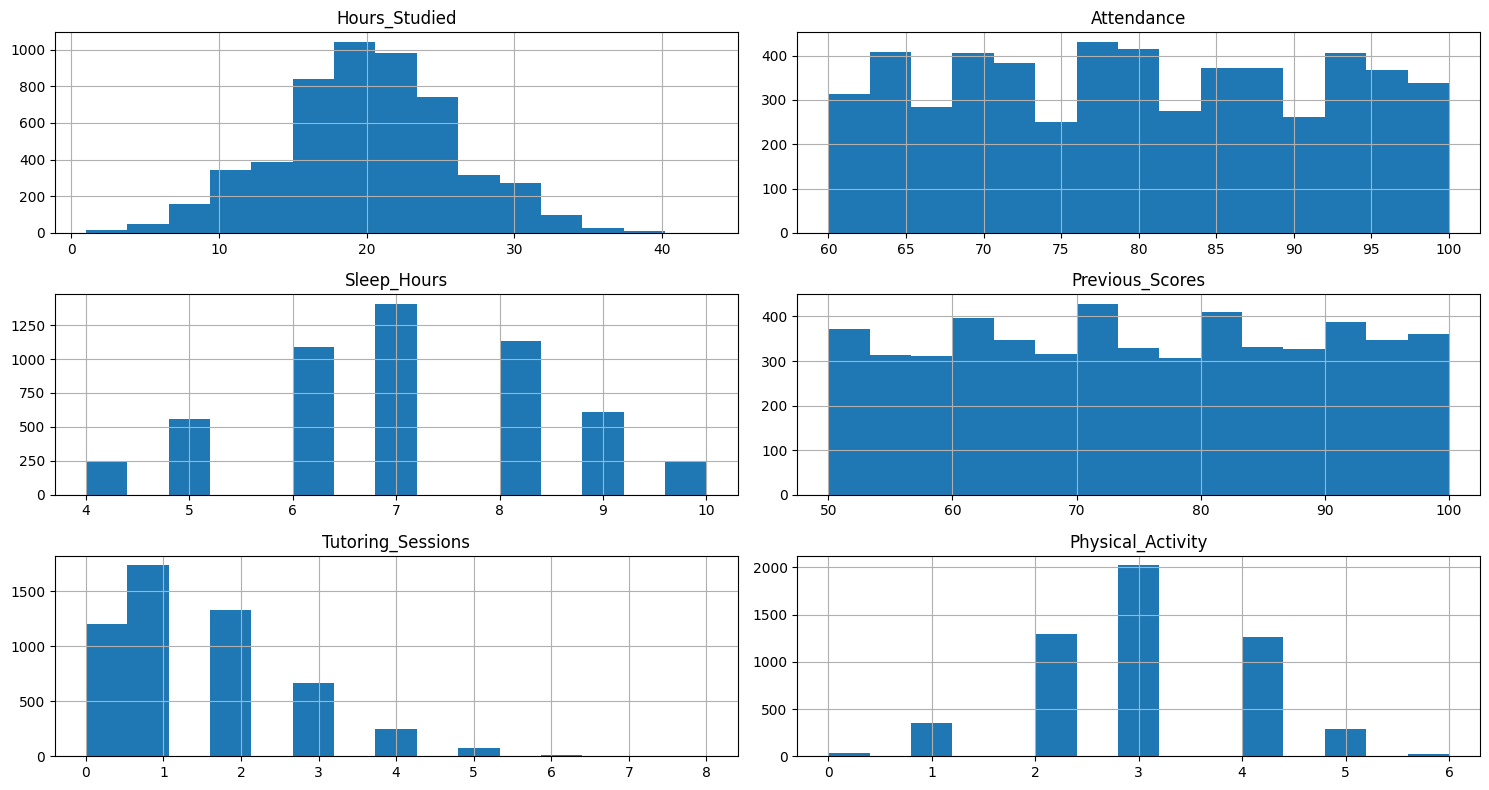

In [ ]:
# Histogram
X_train[num_cols].hist(bins=15, figsize=(15, 8))
plt.tight_layout()
plt.show()

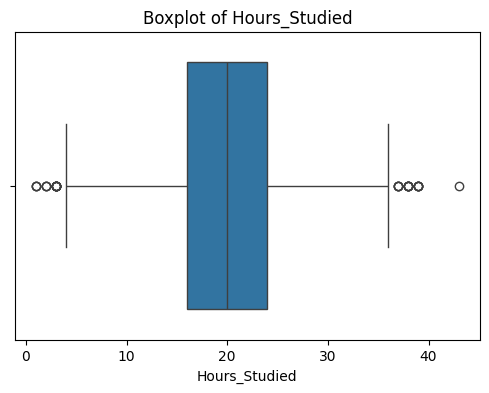

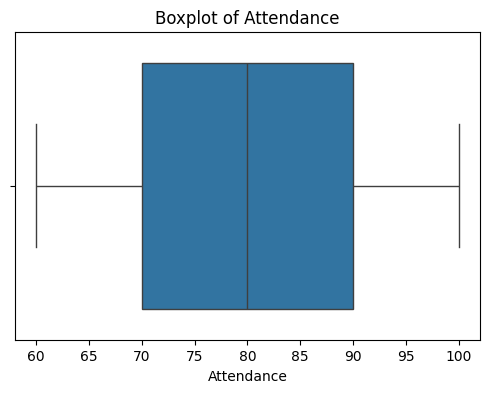

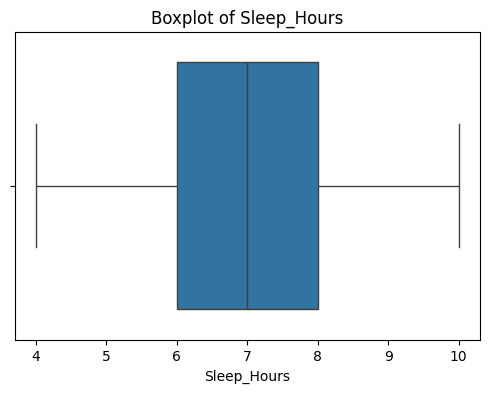

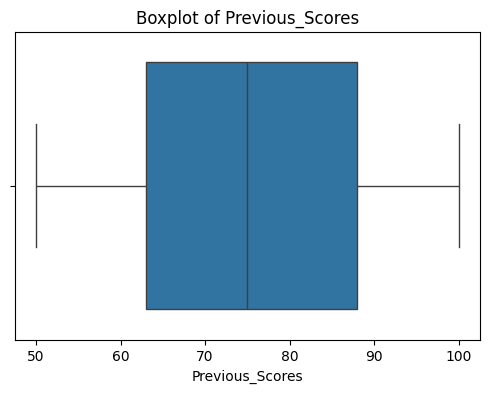

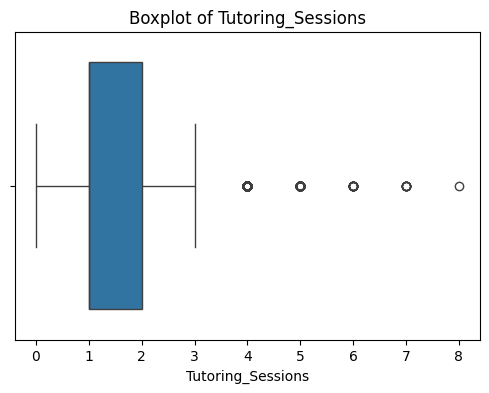

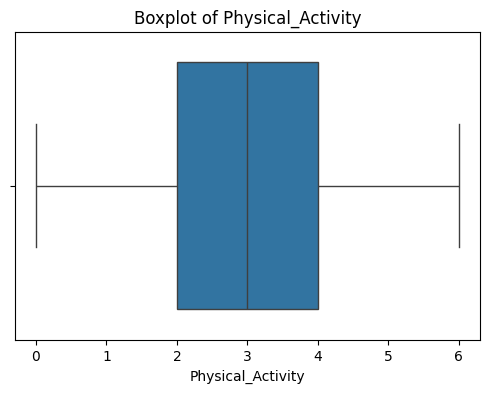

In [ ]:
# Boxplots
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=X_train[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

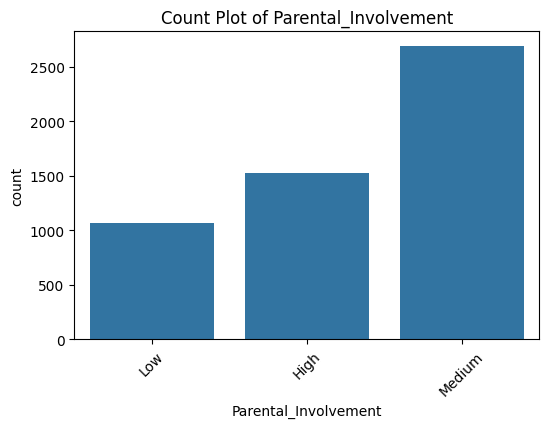

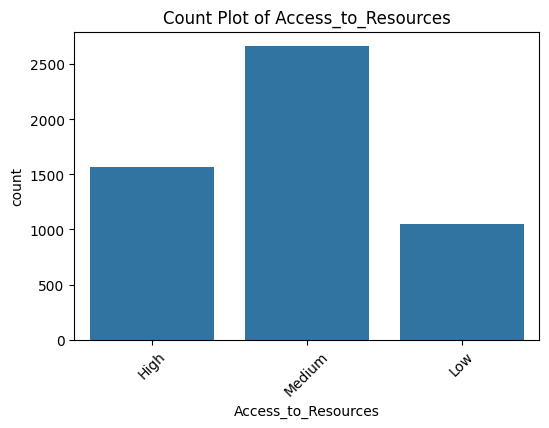

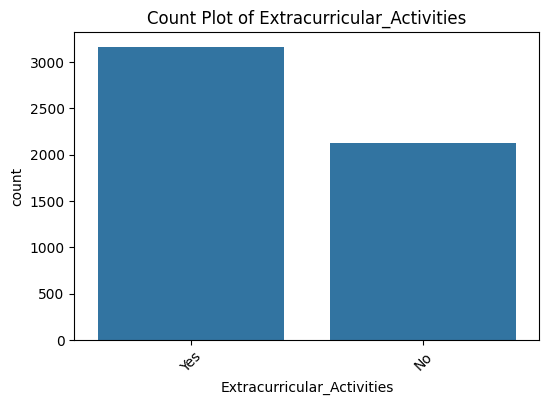

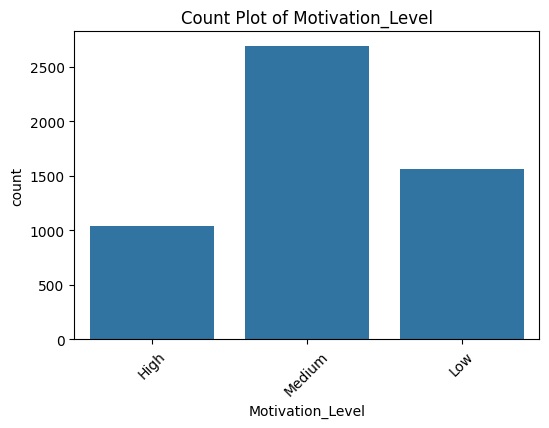

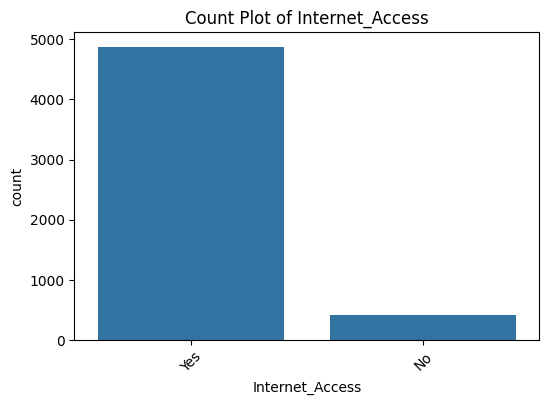

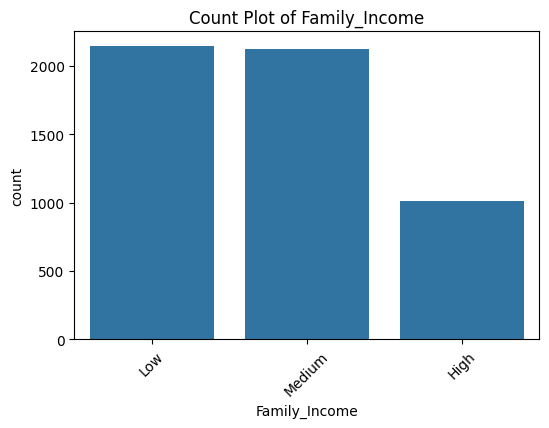

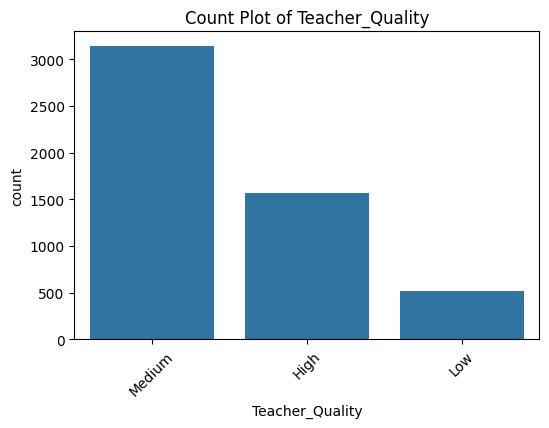

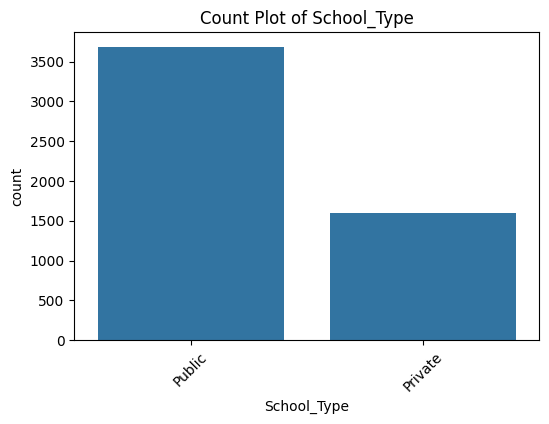

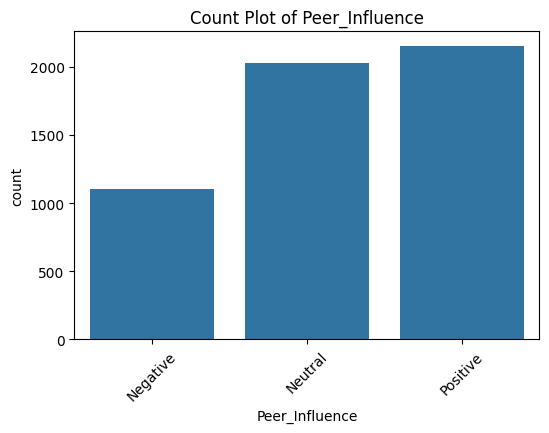

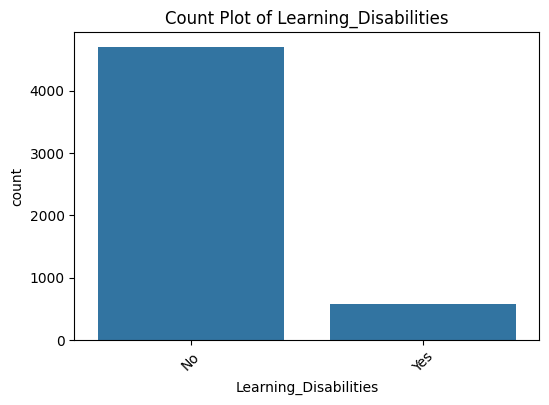

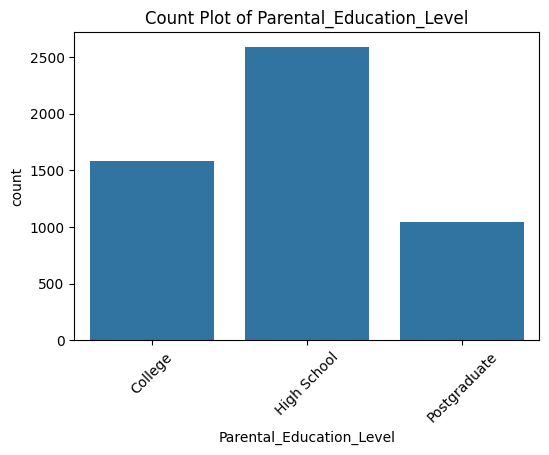

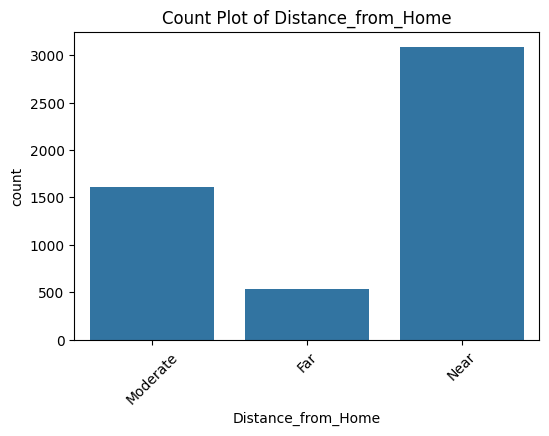

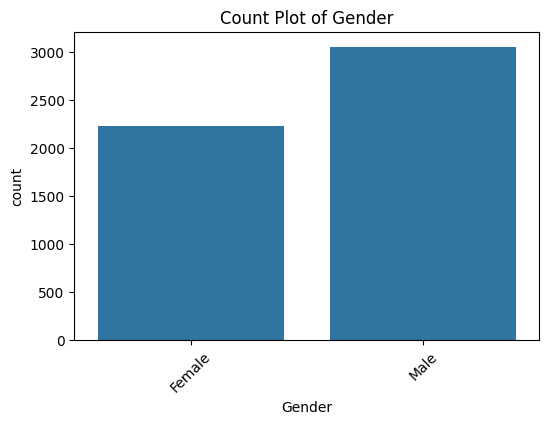

In [ ]:
# Count Plots for Categorical column
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=X_train, x=col)
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
    plt.show()

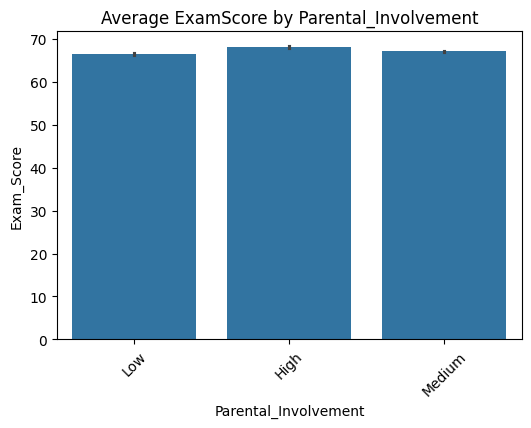

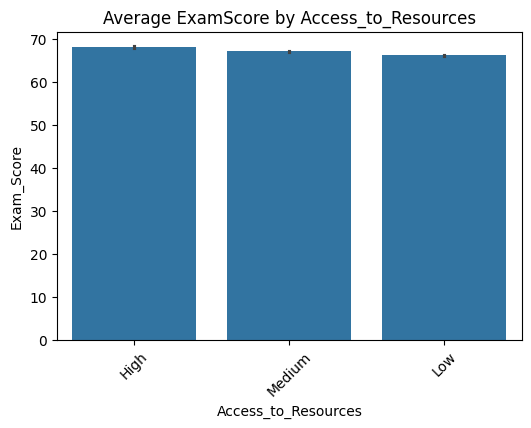

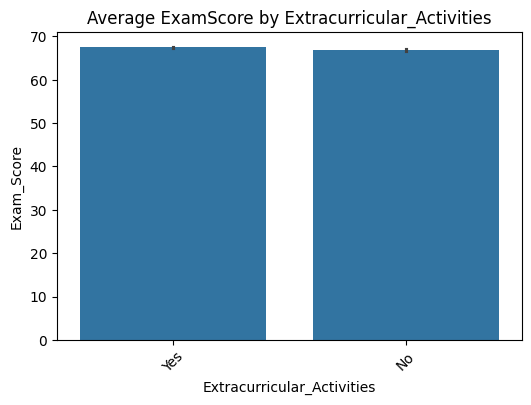

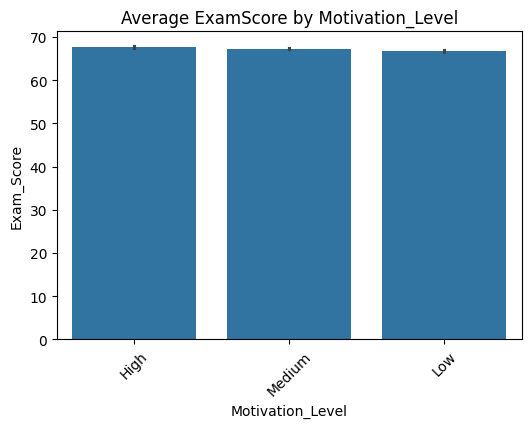

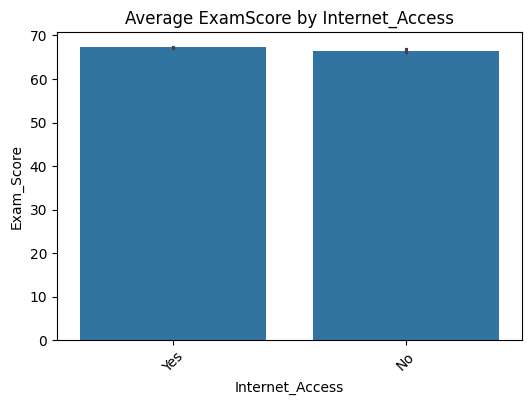

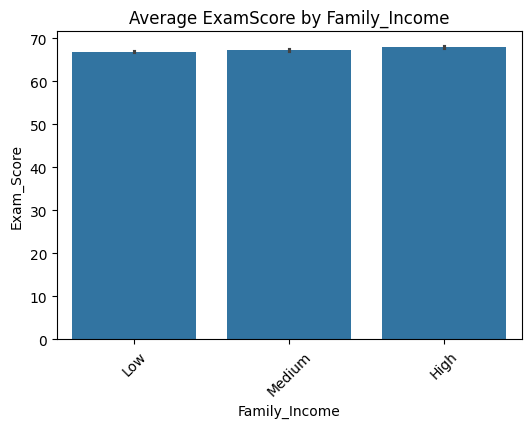

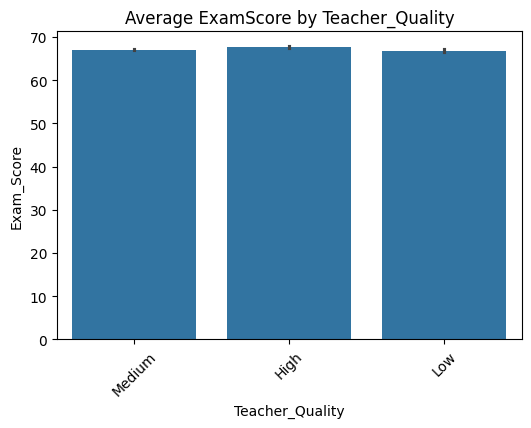

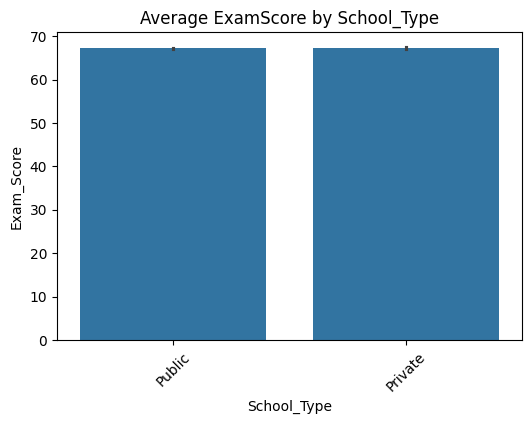

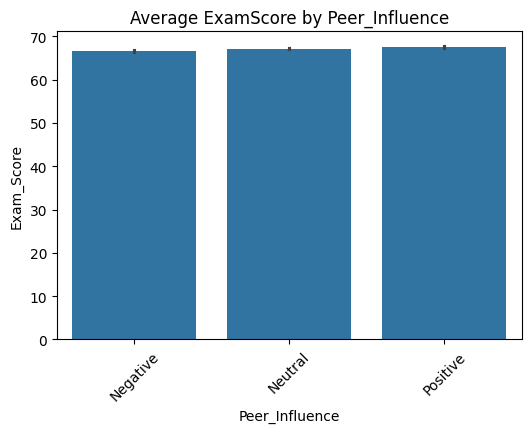

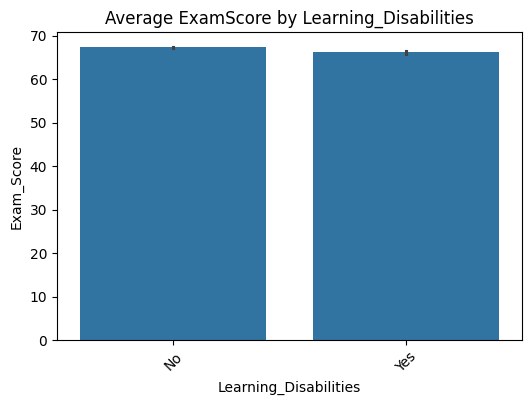

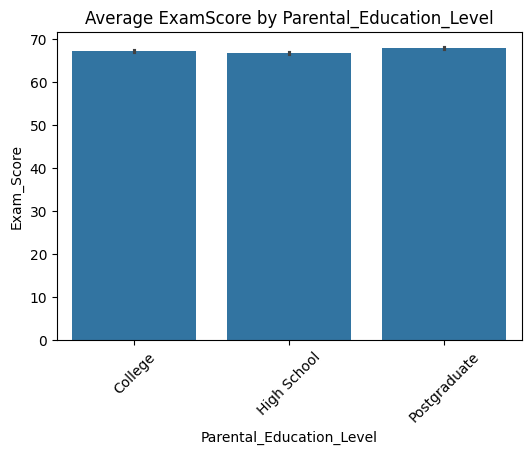

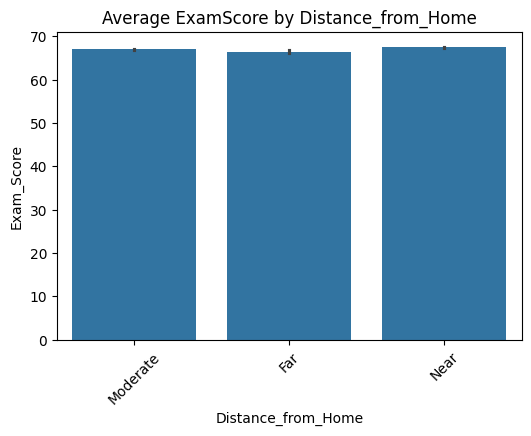

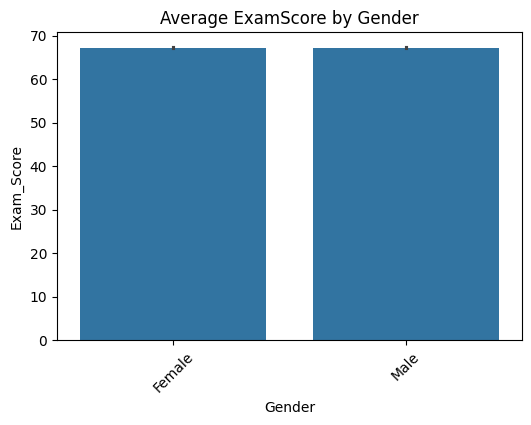

In [ ]:
# Average ExamScore for each Categorical column
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.barplot(data=X_train, x=col, y= y_train, estimator=lambda x: sum(x)/len(x))
    plt.title(f'Average ExamScore by {col}')
    plt.xticks(rotation=45)
    plt.show()

## Handle Outliers

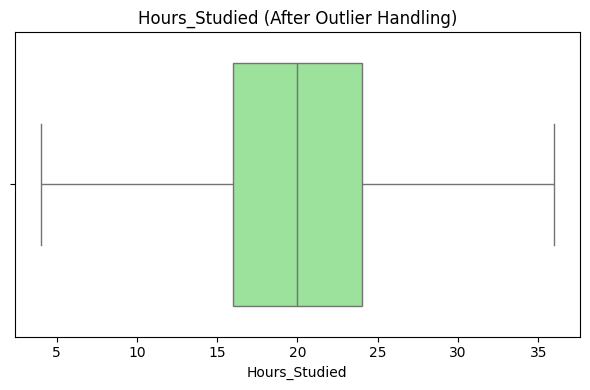

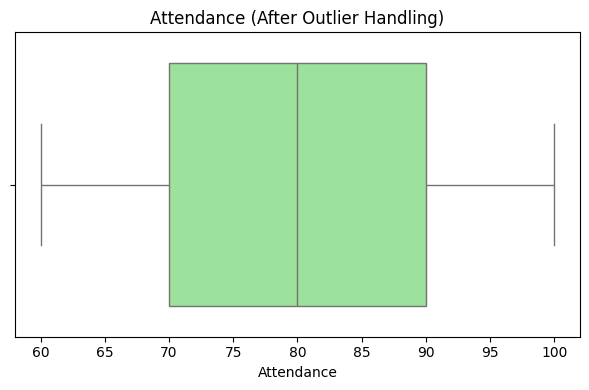

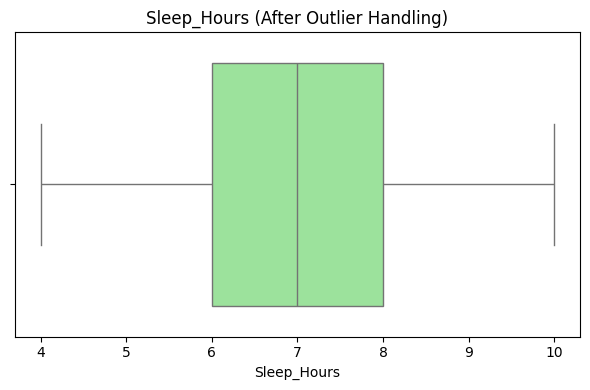

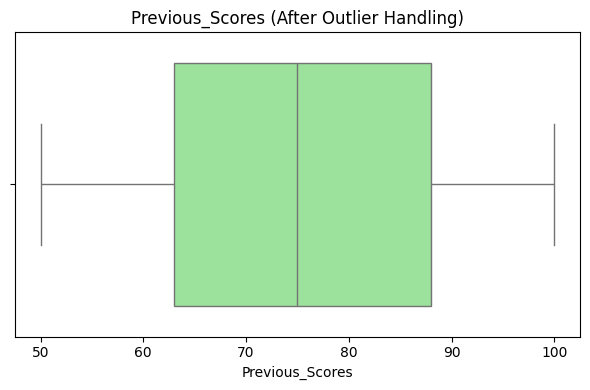

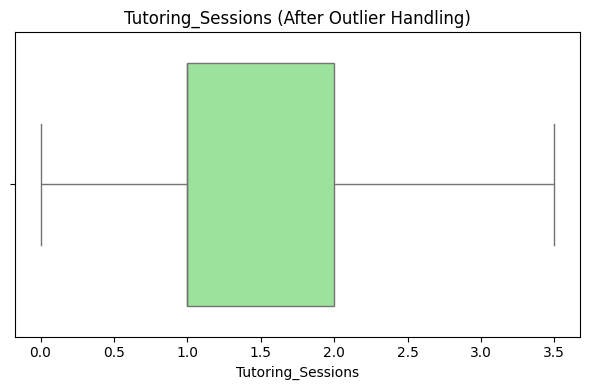

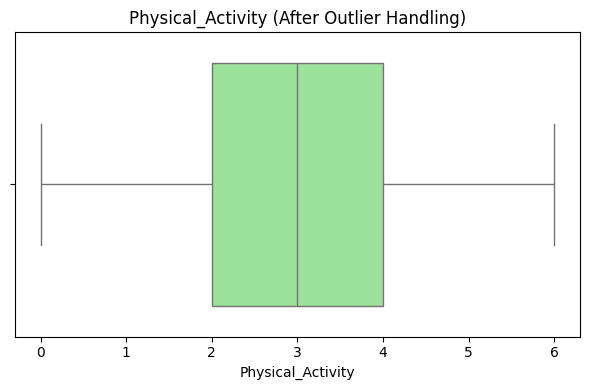

In [ ]:
for col in num_cols:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap values
    X_train[col] = np.where(X_train[col] < lower_bound, lower_bound,np.where(X_train[col] > upper_bound, upper_bound, X_train[col]))
    X_test[col] = np.where(X_test[col] < lower_bound, lower_bound,np.where(X_test[col] > upper_bound, upper_bound, X_test[col]))

    # After plot
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=X_train[col], color='lightgreen')
    plt.title(f'{col} (After Outlier Handling)')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

## Feature Engineering & Encoding

In [ ]:
# Ratio Features
X_train['study_sleep_ratio'] = X_train['Hours_Studied'] / (X_train['Sleep_Hours'] + 1)
X_test['study_sleep_ratio'] = X_test['Hours_Studied'] / (X_test['Sleep_Hours'] + 1)

X_train['study_tutoring_ratio'] = X_train['Hours_Studied'] / (X_train['Tutoring_Sessions'] + 1)
X_test['study_tutoring_ratio'] = X_test['Hours_Studied'] / (X_test['Tutoring_Sessions'] + 1)

X_train['active_hours'] = X_train['Sleep_Hours'] + X_train['Physical_Activity']
X_test['active_hours'] = X_test['Sleep_Hours'] + X_test['Physical_Activity']


In [ ]:
# Normalize Attendance
att_min = X_train['Attendance'].min()
att_max = X_train['Attendance'].max()

X_train['Attendance_norm'] = (X_train['Attendance'] - att_min) / (att_max - att_min)
X_test['Attendance_norm'] = (X_test['Attendance'] - att_min) / (att_max - att_min)  # use train's min/max

X_train['study_efficiency'] = X_train['Hours_Studied'] / (X_train['Attendance_norm'] + 1)
X_test['study_efficiency'] = X_test['Hours_Studied'] / (X_test['Attendance_norm'] + 1)

In [ ]:
le_parent = LabelEncoder()
X_train['ParentalInvolvement_score'] = le_parent.fit_transform(X_train['Parental_Involvement'])
X_test['ParentalInvolvement_score'] = le_parent.transform(X_test['Parental_Involvement'])

le_teacher = LabelEncoder()
X_train['TeacherQuality_score'] = le_teacher.fit_transform(X_train['Teacher_Quality'])
X_test['TeacherQuality_score'] = le_teacher.transform(X_test['Teacher_Quality'])


In [ ]:
X_train['support_score'] = X_train['ParentalInvolvement_score'] + X_train['TeacherQuality_score']
X_test['support_score'] = X_test['ParentalInvolvement_score'] + X_test['TeacherQuality_score']


In [ ]:
# Label encode Family_Income
le_income = LabelEncoder()
X_train['Family_Income_enc'] = le_income.fit_transform(X_train['Family_Income'])
X_test['Family_Income_enc'] = le_income.transform(X_test['Family_Income'])

#  mapping to income_level
income_map = {val: 'Low' if code == 0 else 'Medium' if code == 1 else 'High'for val, code in zip(le_income.classes_, range(len(le_income.classes_)))}

X_train['income_level'] = X_train['Family_Income'].map(income_map)
X_test['income_level'] = X_test['Family_Income'].map(income_map)

X_train['income_teacher_quality'] = X_train['income_level'].astype(str) + "_" + X_train['Teacher_Quality'].astype(str)
X_test['income_teacher_quality'] = X_test['income_level'].astype(str) + "_" + X_test['Teacher_Quality'].astype(str)


## Data Pipelines

In [ ]:
def categorize_columns(df):
    # Columns that we want to label encode
    special_label_cols = ['Parental_Involvement', 'Teacher_Quality', 'Family_Income']

    # Numerical columns (excluding the special ones)
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    num_cols = [col for col in num_cols if col not in special_label_cols]

    # Categorical columns (excluding the special ones)
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    cat_cols = [col for col in cat_cols if col not in special_label_cols]

    return num_cols, cat_cols, special_label_cols

# Example usage
num_cols, cat_cols, special_label_cols = categorize_columns(X_train)

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)
print("Special label columns:", special_label_cols)


Numerical columns: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'study_sleep_ratio', 'study_tutoring_ratio', 'active_hours', 'Attendance_norm', 'study_efficiency', 'ParentalInvolvement_score', 'TeacherQuality_score', 'support_score', 'Family_Income_enc']
Categorical columns: ['Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'income_level', 'income_teacher_quality']
Special label columns: ['Parental_Involvement', 'Teacher_Quality', 'Family_Income']


In [ ]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols + ['study_efficiency']),
    ('cat', cat_pipeline, cat_cols)
])

# Transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Loading Preprocessed Data into files

In [ ]:
df_train = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())
df_train['Exam_Score'] = y_train.values

df_test = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())
df_test['Exam_Score'] = y_test.values


In [ ]:
df_train.to_csv('df_train.csv', index=False)
df_test.to_csv('df_test.csv', index=False)